In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix, hstack
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Load data
data_path = 'cyber.csv'
data = pd.read_csv(data_path)

# Handle missing values
imputer = SimpleImputer(strategy='median')
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Convert 'Timestamp' to datetime and extract hour
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')
data['Hour'] = data['Timestamp'].dt.hour
data['Late Night'] = (data['Hour'] >= 1) & (data['Hour'] <= 6)

# Define 'Is_Attack' based on conditions
data['Is_Attack'] = (
    data['Late Night'] |
    (data['Malware Indicators'] == 'IOC detected') |
    (data['Anomaly Scores'] > 75) |
    (data['Severity Level'] == 'High')
).astype(int)

# Preparing for sparse matrix creation
encoder = OneHotEncoder(drop='first', sparse_output=True)
categorical_cols = data.select_dtypes(include=['object']).columns
data_categorical_encoded = encoder.fit_transform(data[categorical_cols])

# Combine numeric columns with encoded categorical columns
numeric_data = csr_matrix(data[numeric_columns])
X = hstack([numeric_data, data_categorical_encoded], format='csr')
y = data['Is_Attack'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic'
)
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)], verbose=True)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optionally, print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

C:\Users\archi\miniconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65168
[1]	validation_0-logloss:0.62366
[2]	validation_0-logloss:0.61059
[3]	validation_0-logloss:0.58672
[4]	validation_0-logloss:0.58677
[5]	validation_0-logloss:0.56509
[6]	validation_0-logloss:0.54530
[7]	validation_0-logloss:0.53585
[8]	validation_0-logloss:0.51858
[9]	validation_0-logloss:0.51684
[10]	validation_0-logloss:0.50874
[11]	validation_0-logloss:0.49362
[12]	validation_0-logloss:0.48679
[13]	validation_0-logloss:0.47346
[14]	validation_0-logloss:0.47197
[15]	validation_0-logloss:0.46630
[16]	validation_0-logloss:0.45971
[17]	validation_0-logloss:0.44852
[18]	validation_0-logloss:0.43804
[19]	validation_0-logloss:0.42841
[20]	validation_0-logloss:0.42533
[21]	validation_0-logloss:0.42039
[22]	validation_0-logloss:0.41205
[23]	validation_0-logloss:0.40430
[24]	validation_0-logloss:0.40030
[25]	validation_0-logloss:0.39657
[26]	validation_0-logloss:0.39305
[27]	validation_0-logloss:0.38972
[28]	validation_0-logloss:0.38357
[29]	validation_0-loglos

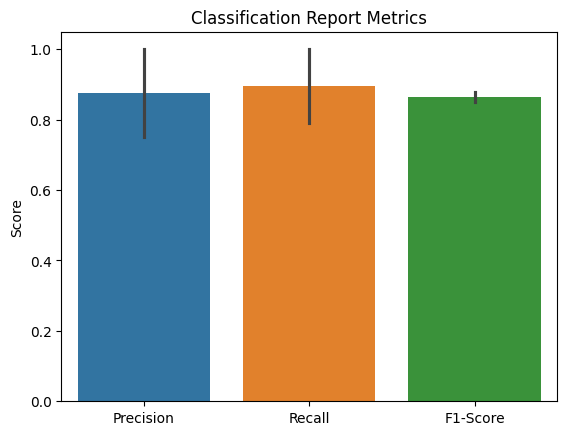

Overall Accuracy: 87.00%


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your classification report
data = {
    'Precision': [0.75, 1.00],
    'Recall': [1.00, 0.79],
    'F1-Score': [0.85, 0.88]
}
classes = ['Not Attack', 'Attack']

# Create a DataFrame
df = pd.DataFrame(data, index=classes)

# Create a bar plot for precision, recall, and f1-score
sns.barplot(data=df)
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.show()

# Display Accuracy
accuracy = 0.87
print(f"Overall Accuracy: {accuracy:.2%}")


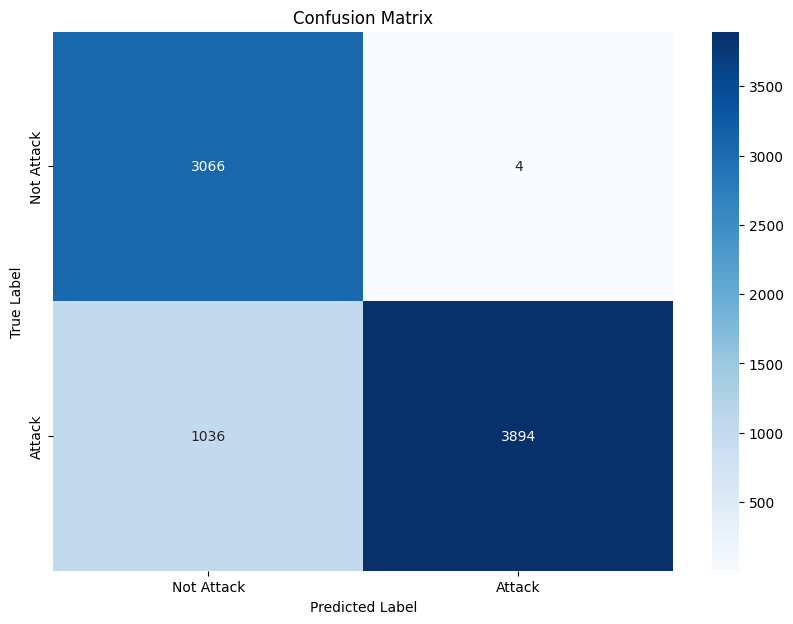

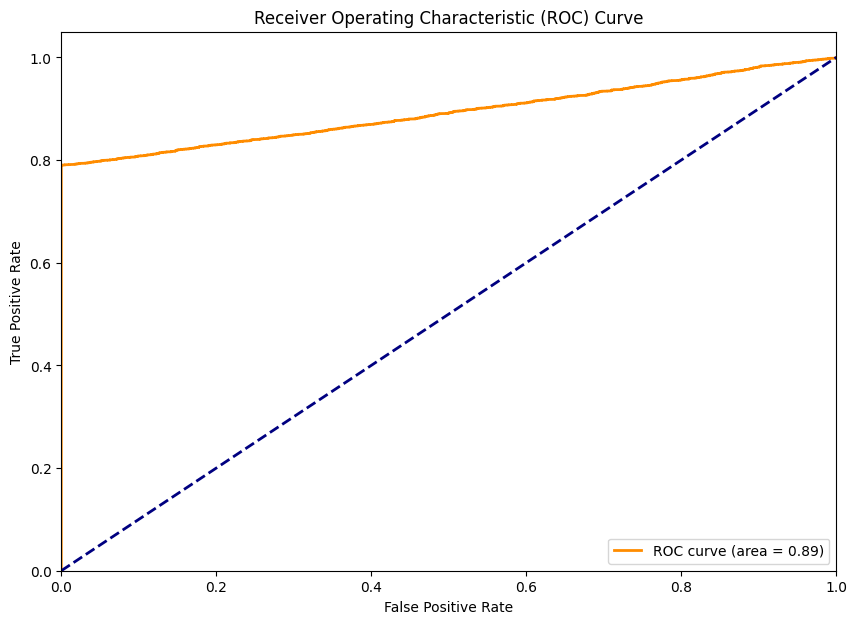

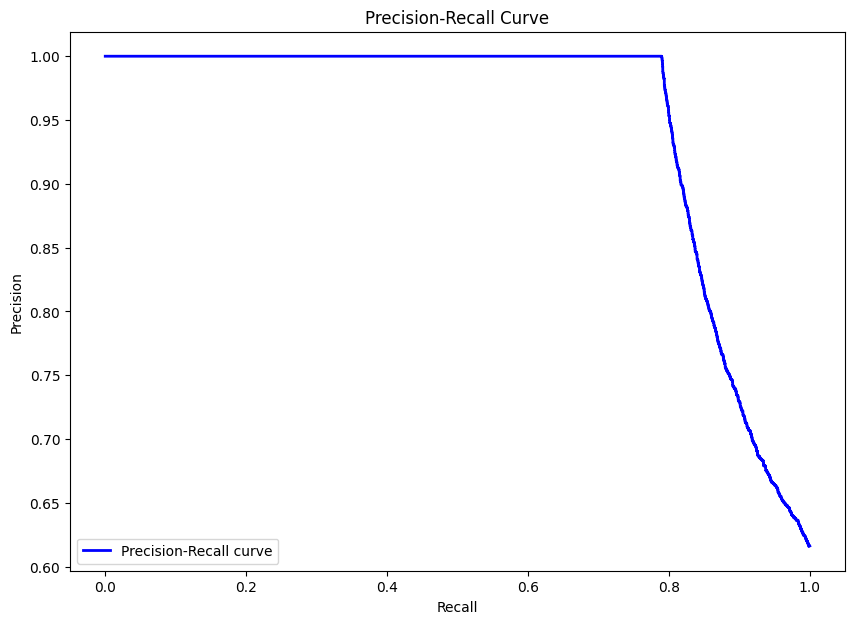

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

# Assuming model, X_test, y_test are already defined and imported
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Attack', 'Attack'], yticklabels=['Not Attack', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()




In [7]:
import numpy as np

# Predict on the entire dataset
y_pred_full = model.predict(X)

# Convert predictions from 0 or 1 to 'Not Attack' or 'Attack'
predictions_labels = np.where(y_pred_full == 1, 'Attack', 'Not Attack')

# Add predictions to the original DataFrame
data['Predictions'] = predictions_labels

# Save the DataFrame with predictions to an Excel file
output_path = 'predictions_cyber.xlsx'
data.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to predictions_cyber.xlsx
